## Setting up kaggle api

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayushjain00","key":"baae21a8725dfe4633fa7de2db97885b"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
 ! chmod 600 ~/.kaggle/kaggle.json

## Downloading Dataset

In [6]:
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.61G/1.62G [00:49<00:00, 39.7MB/s]
100% 1.62G/1.62G [00:49<00:00, 34.8MB/s]


In [7]:
! mkdir dataset

In [8]:
! unzip 100-bird-species.zip -d dataset/

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/TOUCHAN/003.jpg  
  inflating: dataset/train/TOUCHAN/004.jpg  
  inflating: dataset/train/TOUCHAN/005.jpg  
  inflating: dataset/train/TOUCHAN/006.jpg  
  inflating: dataset/train/TOUCHAN/007.jpg  
  inflating: dataset/train/TOUCHAN/008.jpg  
  inflating: dataset/train/TOUCHAN/009.jpg  
  inflating: dataset/train/TOUCHAN/010.jpg  
  inflating: dataset/train/TOUCHAN/011.jpg  
  inflating: dataset/train/TOUCHAN/012.jpg  
  inflating: dataset/train/TOUCHAN/013.jpg  
  inflating: dataset/train/TOUCHAN/014.jpg  
  inflating: dataset/train/TOUCHAN/015.jpg  
  inflating: dataset/train/TOUCHAN/016.jpg  
  inflating: dataset/train/TOUCHAN/017.jpg  
  inflating: dataset/train/TOUCHAN/018.jpg  
  inflating: dataset/train/TOUCHAN/019.jpg  
  inflating: dataset/train/TOUCHAN/020.jpg  
  inflating: dataset/train/TOUCHAN/021.jpg  
  inflating: dataset/train/TOUCHAN/022.jpg  
  inflating: dataset/train/TOUCHAN/023.jpg  
  in

In [9]:
!ls

100-bird-species.zip  dataset  kaggle.json  sample_data


## Importing Libraries

In [10]:
import os
import cv2
import gc

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plot

import keras.models as Models
import keras.layers as Layers

from keras.applications import VGG19
from keras.applications import InceptionV3

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from sklearn.model_selection import train_test_split

from random import randint

## Reading Dataset

In [11]:
os.chdir('./dataset')
os.listdir()

['consolidated', 'valid', 'test', 'train']

#### Reading entire dataset

In [12]:
labels_classes = []
labels_ids = []
def get_images(directory):
    Images = []
    Labels = []
    label_count = 0
    
    for label in os.listdir(directory):
        if label not in labels_classes:
            labels_classes.append(label)
            labels_ids.append(label_count)
            label_count+=1
            
        for image_file in os.listdir(directory + label):
            image = cv2.imread(directory + label + '/' + image_file)
            image = cv2.resize(image, (224, 224))
            Images.append(image)
            Labels.append(labels_ids[labels_classes.index(label)])
            
    return shuffle(Images, Labels, random_state = 246810)
            
def get_classlabel(class_code):    
    return labels_classes[class_code]

In [13]:
Images, Labels = get_images('./train/')
Images_test, Labels_test = get_images('./test/')
Images_validate, Labels_validate = get_images('./valid/')

In [14]:
Images = np.array(Images)
Labels = np.array(Labels)
Images_test = np.array(Images_test)
Labels_test = np.array(Labels_test)
Images_validate = np.array(Images_validate)
Labels_validate = np.array(Labels_validate)

In [15]:
Images.shape

(36609, 224, 224, 3)

In [16]:
len(labels_classes)

260

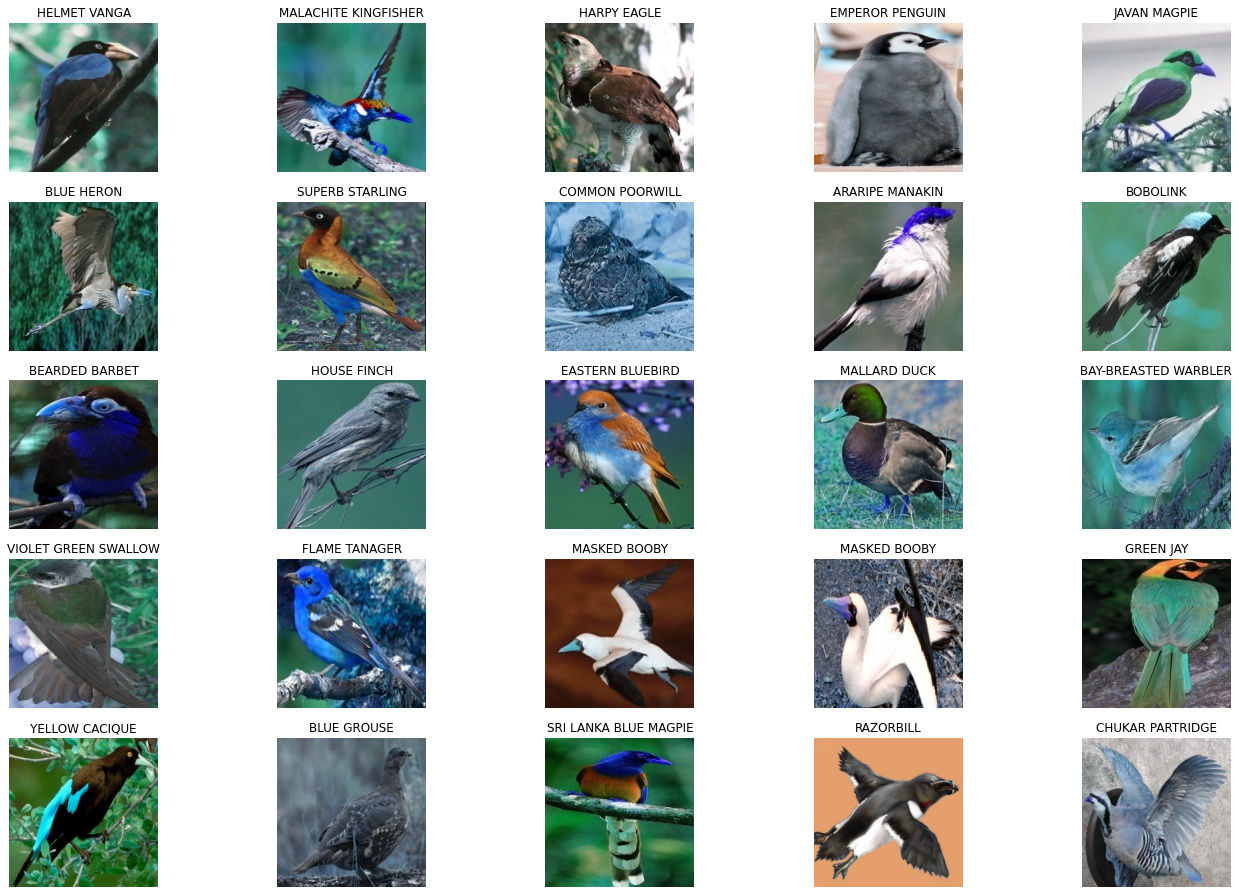

In [17]:
f, ax = plot.subplots(5, 5)
f.subplots_adjust(0,0,3,3)

for i in range(0,5,1):
    for j in range(0,5,1):
        random_number = randint(0, len(Images))
        ax[i,j].imshow(Images[random_number])
        ax[i,j].set_title(get_classlabel(Labels[random_number]))
        ax[i,j].axis('off')

#### Reading a dataset of only 50 bird species

In [18]:
labels50_classes = []
labels50_ids = []
def get_50images(directory):
    Images = []
    Labels = []
    label_count = 0
    
    for label in os.listdir(directory):
        if label not in labels50_classes:
            labels50_classes.append(label)
            labels50_ids.append(label_count)
            label_count+=1
            
        for image_file in os.listdir(directory + label):
            image = cv2.imread(directory + label + '/' + image_file)
            image = cv2.resize(image, (224, 224))
            Images.append(image)
            Labels.append(labels50_ids[labels50_classes.index(label)])

        if label_count==50:
            break
    return shuffle(Images, Labels, random_state = 246810)
            
def get_50classlabel(class_code):
    
    return labels50_classes[class_code]

In [19]:
def get_50_valid_images(directory):
    Images = []
    Labels = []
    
    for label in labels50_classes:
        for image_file in os.listdir(directory + '/' + label):
            image = cv2.imread(directory + '/' + label + '/' + image_file)
            image = cv2.resize(image, (224, 224))
            Images.append(image)
            Labels.append(labels50_ids[labels50_classes.index(label)])

    return shuffle(Images, Labels, random_state = 246810)

In [20]:
Images50, Labels50 = get_50images('./train/')

In [21]:
len(labels50_classes)

50

In [22]:
Images50_val, Labels50_val = get_50_valid_images('./valid/')
Images50_test, Labels50_test = get_50_valid_images('./test/')

In [23]:
Images50 = np.array(Images50)
Labels50 = np.array(Labels50)
Images50_val = np.array(Images50_val)
Labels50_val = np.array(Labels50_val)
Images50_test = np.array(Images50_test)
Labels50_test = np.array(Labels50_test)

In [24]:
Images50.shape

(6852, 224, 224, 3)

## Testing on a dataset of 50 bird species

#### Custom model, 79% accuracy

In [25]:
gc.collect()

model = Models.Sequential()
#layer1
model.add(Layers.Conv2D(40, 5, activation = 'relu', input_shape = (224, 224, 3)))
model.add(Layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Layers.BatchNormalization())

#Layer2
model.add(Layers.Conv2D(50, 3, activation = 'relu'))
model.add(Layers.MaxPool2D(pool_size=(3, 3), strides=(3, 3)))
model.add(Layers.BatchNormalization())

#Layer3
model.add(Layers.Conv2D(70, 5, activation = 'relu'))
model.add(Layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Layers.BatchNormalization())

#Layer3
model.add(Layers.Conv2D(100, 3, activation = 'relu'))
model.add(Layers.MaxPool2D(pool_size=(5, 5), strides=(5, 5)))
model.add(Layers.BatchNormalization())

model.add(Layers.Flatten())
model.add(Layers.Activation('relu'))
model.add(Layers.Dropout(0.5))
model.add(Layers.Dense(50, activation = 'softmax'))
model.compile(metrics = ['accuracy'], loss = 'sparse_categorical_crossentropy', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 40)      3040      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 40)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 110, 110, 40)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 50)      18050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 50)        200       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 70)        8

In [26]:
trained = model.fit(Images50, Labels50, validation_data=(Images50_val, Labels50_val), epochs=50)

Epoch 1/50
215/215 [==============================] - 23s 31ms/step - loss: 4.0021 - accuracy: 0.0850 - val_loss: 2.8536 - val_accuracy: 0.2480
Epoch 2/50
215/215 [==============================] - 6s 28ms/step - loss: 2.7697 - accuracy: 0.2588 - val_loss: 2.6752 - val_accuracy: 0.2840
Epoch 3/50
215/215 [==============================] - 6s 28ms/step - loss: 2.2402 - accuracy: 0.3919 - val_loss: 1.9488 - val_accuracy: 0.4720
Epoch 4/50
215/215 [==============================] - 6s 28ms/step - loss: 1.9442 - accuracy: 0.4756 - val_loss: 2.3715 - val_accuracy: 0.3800
Epoch 5/50
215/215 [==============================] - 6s 28ms/step - loss: 1.7414 - accuracy: 0.5202 - val_loss: 1.6137 - val_accuracy: 0.5680
Epoch 6/50
215/215 [==============================] - 6s 28ms/step - loss: 1.5544 - accuracy: 0.5624 - val_loss: 1.3647 - val_accuracy: 0.6320
Epoch 7/50
215/215 [==============================] - 6s 28ms/step - loss: 1.4038 - accuracy: 0.6039 - val_loss: 1.1300 - val_accuracy: 0.696

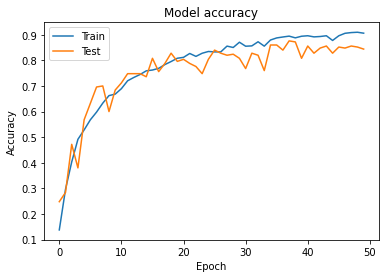

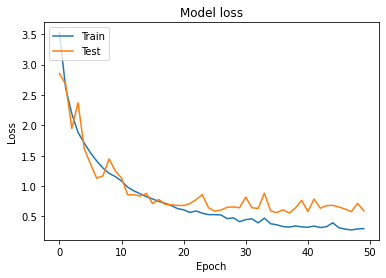

In [27]:
plot.plot(trained.history['accuracy'])
plot.plot(trained.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [28]:
from sklearn.metrics import classification_report
print(classification_report(Labels50_test, np.argmax(model.predict(Images50_test), axis=1)))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       1.00      1.00      1.00         5
           2       0.67      0.80      0.73         5
           3       0.80      0.80      0.80         5
           4       0.71      1.00      0.83         5
           5       0.50      0.40      0.44         5
           6       0.83      1.00      0.91         5
           7       1.00      0.60      0.75         5
           8       0.80      0.80      0.80         5
           9       0.67      0.80      0.73         5
          10       0.83      1.00      0.91         5
          11       0.80      0.80      0.80         5
          12       0.80      0.80      0.80         5
          13       0.80      0.80      0.80         5
          14       0.75      0.60      0.67         5
          15       0.80      0.80      0.80         5
          16       1.00      1.00      1.00         5
          17       1.00    

#### InceptionV3 model, 45% accuracy

In [29]:
model = Models.Sequential()
inceptionLayer = InceptionV3 (weights = 'imagenet', 
                  include_top = False,
                  input_shape = (224, 224, 3))
inceptionLayer.trainable=False
model.add(inceptionLayer)
model.add(Layers.BatchNormalization())
model.add(Layers.Flatten())
model.add(Layers.Activation('relu'))
model.add(Layers.Dropout(0.5))
model.add(Layers.Dense(50, activation = 'softmax'))
model.compile(metrics = ['accuracy'], loss = 'sparse_categorical_crossentropy', optimizer = 'adam')
model.summary()

87916544/87910968 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
batch_normalization_98 (Batc (None, 5, 5, 2048)        8192      
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
activation_95 (Activation)   (None, 51200)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2560050   
Total params: 24,371,026
Trainable params: 2,564,146
No

In [30]:
trained = model.fit(Images50, Labels50, validation_data=(Images50_val, Labels50_val), epochs=80)

Epoch 1/80
215/215 [==============================] - 15s 51ms/step - loss: 11.3462 - accuracy: 0.1158 - val_loss: 8.8930 - val_accuracy: 0.2640
Epoch 2/80
215/215 [==============================] - 9s 43ms/step - loss: 4.8441 - accuracy: 0.4512 - val_loss: 8.3349 - val_accuracy: 0.3000
Epoch 3/80
215/215 [==============================] - 9s 43ms/step - loss: 2.8732 - accuracy: 0.5910 - val_loss: 7.6177 - val_accuracy: 0.3840
Epoch 4/80
215/215 [==============================] - 9s 43ms/step - loss: 1.8458 - accuracy: 0.7053 - val_loss: 7.7052 - val_accuracy: 0.3560
Epoch 5/80
215/215 [==============================] - 9s 43ms/step - loss: 1.4036 - accuracy: 0.7573 - val_loss: 8.1840 - val_accuracy: 0.3520
Epoch 6/80
215/215 [==============================] - 9s 43ms/step - loss: 1.0667 - accuracy: 0.8136 - val_loss: 7.6463 - val_accuracy: 0.3920
Epoch 7/80
215/215 [==============================] - 9s 43ms/step - loss: 0.8244 - accuracy: 0.8431 - val_loss: 7.3961 - val_accuracy: 0.41

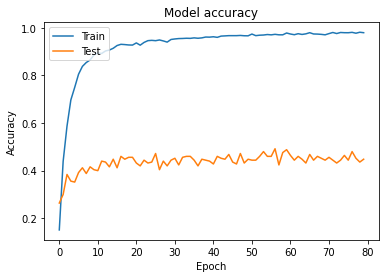

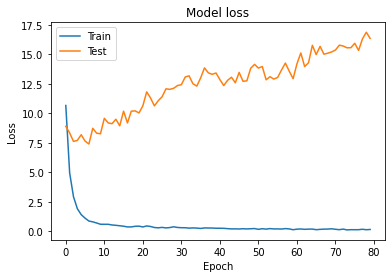

In [31]:
plot.plot(trained.history['accuracy'])
plot.plot(trained.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [32]:
from sklearn.metrics import classification_report
print(classification_report(Labels50_test, np.argmax(model.predict(Images50_test), axis=1)))

              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.00      0.00      0.00         5
           2       0.33      0.40      0.36         5
           3       0.43      0.60      0.50         5
           4       0.00      0.00      0.00         5
           5       0.17      0.20      0.18         5
           6       0.40      0.80      0.53         5
           7       0.00      0.00      0.00         5
           8       0.43      0.60      0.50         5
           9       0.67      0.80      0.73         5
          10       0.75      0.60      0.67         5
          11       0.43      0.60      0.50         5
          12       0.00      0.00      0.00         5
          13       0.24      0.80      0.36         5
          14       0.80      0.80      0.80         5
          15       0.50      0.40      0.44         5
          16       0.33      0.20      0.25         5
          17       0.50    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### VGG19 Model, 96% accuracy

In [33]:
model = Models.Sequential()
vgg19Layer = VGG19 (weights = 'imagenet', 
                  include_top = False,
                  input_shape = (224, 224, 3))
vgg19Layer.trainable = False
model.add(vgg19Layer)
model.add(Layers.BatchNormalization())
model.add(Layers.Flatten())
model.add(Layers.Activation('relu'))
model.add(Layers.Dropout(0.5))
model.add(Layers.Dense(50, activation = 'softmax'))
model.compile(metrics = ['accuracy'], loss = 'sparse_categorical_crossentropy', optimizer = 'adam')
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
batch_normalization_99 (Batc (None, 7, 7, 512)         2048      
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
activation_96 (Activation)   (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1254450   
Total params: 21,280,882
Trainable params: 1,255,474
No

In [34]:
trained = model.fit(Images50, Labels50, validation_data=(Images50_val, Labels50_val), epochs=50)

Epoch 1/50
215/215 [==============================] - 22s 87ms/step - loss: 2.2054 - accuracy: 0.5606 - val_loss: 0.2582 - val_accuracy: 0.9280
Epoch 2/50
215/215 [==============================] - 16s 73ms/step - loss: 0.0859 - accuracy: 0.9774 - val_loss: 0.2844 - val_accuracy: 0.9440
Epoch 3/50
215/215 [==============================] - 16s 73ms/step - loss: 0.0385 - accuracy: 0.9898 - val_loss: 0.2644 - val_accuracy: 0.9440
Epoch 4/50
215/215 [==============================] - 16s 73ms/step - loss: 0.0318 - accuracy: 0.9911 - val_loss: 0.2532 - val_accuracy: 0.9360
Epoch 5/50
215/215 [==============================] - 16s 73ms/step - loss: 0.0215 - accuracy: 0.9940 - val_loss: 0.2971 - val_accuracy: 0.9320
Epoch 6/50
215/215 [==============================] - 16s 73ms/step - loss: 0.0249 - accuracy: 0.9929 - val_loss: 0.2719 - val_accuracy: 0.9400
Epoch 7/50
215/215 [==============================] - 16s 73ms/step - loss: 0.0192 - accuracy: 0.9952 - val_loss: 0.2766 - val_accuracy:

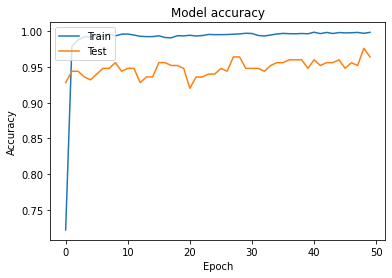

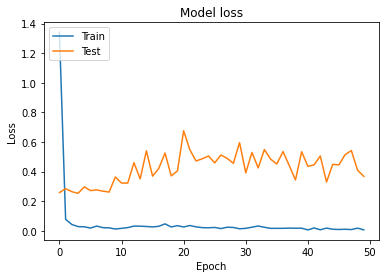

In [35]:
plot.plot(trained.history['accuracy'])
plot.plot(trained.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [36]:
from sklearn.metrics import classification_report
print(classification_report(Labels50_test, np.argmax(model.predict(Images50_test), axis=1)))

              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       0.83      1.00      0.91         5
          11       1.00      0.80      0.89         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       0.83      1.00      0.91         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

## Training on entire dataset

#### 83% accuracy with custom model


In [37]:
gc.collect()

model = Models.Sequential()
#layer1
model.add(Layers.Conv2D(40, 5, activation = 'relu', input_shape = (224, 224, 3)))
model.add(Layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Layers.BatchNormalization())

#Layer2
model.add(Layers.Conv2D(50, 3, activation = 'relu'))
model.add(Layers.MaxPool2D(pool_size=(3, 3), strides=(3, 3)))
model.add(Layers.BatchNormalization())

#Layer3
model.add(Layers.Conv2D(70, 5, activation = 'relu'))
model.add(Layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Layers.BatchNormalization())

#Layer3
model.add(Layers.Conv2D(100, 3, activation = 'relu'))
model.add(Layers.MaxPool2D(pool_size=(5, 5), strides=(5, 5)))
model.add(Layers.BatchNormalization())

model.add(Layers.Flatten())
model.add(Layers.Activation('relu'))
model.add(Layers.Dropout(0.5))
model.add(Layers.Dense(260, activation = 'softmax'))
model.compile(metrics = ['accuracy'], loss = 'sparse_categorical_crossentropy', optimizer = 'adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 220, 220, 40)      3040      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 110, 110, 40)      0         
_________________________________________________________________
batch_normalization_100 (Bat (None, 110, 110, 40)      160       
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 108, 108, 50)      18050     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 50)        0         
_________________________________________________________________
batch_normalization_101 (Bat (None, 36, 36, 50)        200       
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 32, 32, 70)       

In [38]:
trained = model.fit(Images, Labels, validation_data=(Images_validate, Labels_validate), epochs=50)

Epoch 1/50
1145/1145 [==============================] - 33s 28ms/step - loss: 5.1267 - accuracy: 0.0607 - val_loss: 3.4993 - val_accuracy: 0.2477
Epoch 2/50
1145/1145 [==============================] - 32s 28ms/step - loss: 3.3013 - accuracy: 0.2666 - val_loss: 2.3892 - val_accuracy: 0.4292
Epoch 3/50
1145/1145 [==============================] - 32s 28ms/step - loss: 2.7375 - accuracy: 0.3754 - val_loss: 1.8829 - val_accuracy: 0.5446
Epoch 4/50
1145/1145 [==============================] - 32s 28ms/step - loss: 2.3269 - accuracy: 0.4561 - val_loss: 1.7862 - val_accuracy: 0.5808
Epoch 5/50
1145/1145 [==============================] - 32s 28ms/step - loss: 2.1925 - accuracy: 0.4836 - val_loss: 1.4521 - val_accuracy: 0.6615
Epoch 6/50
1145/1145 [==============================] - 32s 28ms/step - loss: 1.9943 - accuracy: 0.5176 - val_loss: 1.4916 - val_accuracy: 0.6400
Epoch 7/50
1145/1145 [==============================] - 32s 28ms/step - loss: 1.8762 - accuracy: 0.5430 - val_loss: 1.3277 -

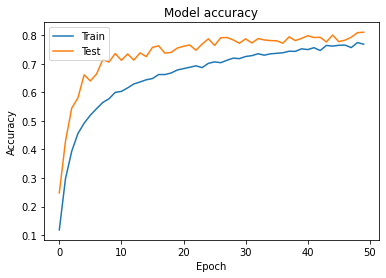

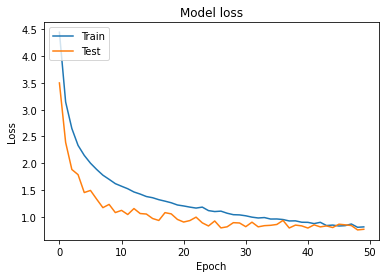

In [39]:
plot.plot(trained.history['accuracy'])
plot.plot(trained.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [40]:
from sklearn.metrics import classification_report
print(classification_report(Labels_test, np.argmax(model.predict(Images_test), axis=1)))

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       1.00      0.60      0.75         5
           2       0.71      1.00      0.83         5
           3       0.71      1.00      0.83         5
           4       0.80      0.80      0.80         5
           5       1.00      0.60      0.75         5
           6       0.62      1.00      0.77         5
           7       1.00      0.60      0.75         5
           8       0.83      1.00      0.91         5
           9       1.00      0.80      0.89         5
          10       1.00      1.00      1.00         5
          11       0.83      1.00      0.91         5
          12       1.00      0.80      0.89         5
          13       0.71      1.00      0.83         5
          14       1.00      0.80      0.89         5
          15       1.00      0.80      0.89         5
          16       0.83      1.00      0.91         5
          17       0.80    

#### InceptionV3 model, % accuracy

In [41]:
model = Models.Sequential()
inceptionLayer = InceptionV3 (weights = 'imagenet', 
                  include_top = False,
                  input_shape = (224, 224, 3))

model.add(inceptionLayer)
model.add(Layers.BatchNormalization())
model.add(Layers.Flatten())
model.add(Layers.Activation('relu'))
model.add(Layers.Dropout(0.5))
model.add(Layers.Dense(260, activation = 'softmax'))
model.compile(metrics = ['accuracy'], loss = 'sparse_categorical_crossentropy', optimizer = 'rmsprop')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
batch_normalization_198 (Bat (None, 5, 5, 2048)        8192      
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
activation_192 (Activation)  (None, 51200)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 260)               13312260  
Total params: 35,123,236
Trainable params: 35,084,708
Non-trainable params: 38,528
_____________________________________

In [42]:
trained = model.fit(Images, Labels, validation_data=(Images_validate, Labels_validate), epochs=80)

Epoch 1/80
1145/1145 [==============================] - 183s 151ms/step - loss: 7.8062 - accuracy: 0.0060 - val_loss: 117.3181 - val_accuracy: 0.0123
Epoch 2/80
1145/1145 [==============================] - 171s 149ms/step - loss: 6.7497 - accuracy: 0.0166 - val_loss: 6.5420 - val_accuracy: 0.0177
Epoch 3/80
1145/1145 [==============================] - 171s 149ms/step - loss: 6.0403 - accuracy: 0.0366 - val_loss: 35.7665 - val_accuracy: 0.0492
Epoch 4/80
1145/1145 [==============================] - 171s 149ms/step - loss: 5.3377 - accuracy: 0.0807 - val_loss: 26.5137 - val_accuracy: 0.0869
Epoch 5/80
1145/1145 [==============================] - 171s 149ms/step - loss: 4.8040 - accuracy: 0.1253 - val_loss: 8.4338 - val_accuracy: 0.0331
Epoch 6/80
1145/1145 [==============================] - 171s 149ms/step - loss: 4.3141 - accuracy: 0.1560 - val_loss: 6.1932 - val_accuracy: 0.1785
Epoch 7/80
1145/1145 [==============================] - 171s 149ms/step - loss: 3.8378 - accuracy: 0.2087 - 

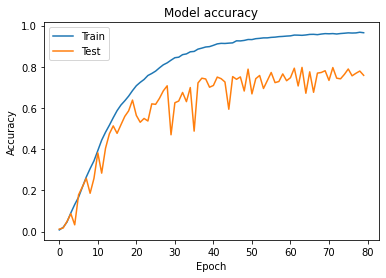

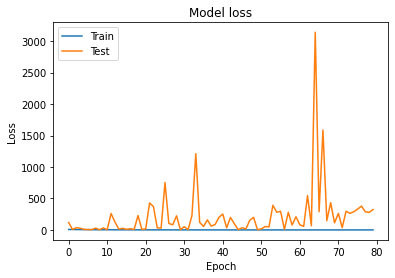

In [43]:
plot.plot(trained.history['accuracy'])
plot.plot(trained.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [44]:
from sklearn.metrics import classification_report
print(classification_report(Labels_test, np.argmax(model.predict(Images_test), axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.80      0.80      0.80         5
           2       0.80      0.80      0.80         5
           3       0.38      1.00      0.56         5
           4       0.67      0.40      0.50         5
           5       1.00      0.40      0.57         5
           6       1.00      1.00      1.00         5
           7       0.71      1.00      0.83         5
           8       1.00      0.80      0.89         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       0.62      1.00      0.77         5
          12       0.10      0.40      0.16         5
          13       0.67      0.80      0.73         5
          14       1.00      0.60      0.75         5
          15       1.00      0.80      0.89         5
          16       0.67      0.80      0.73         5
          17       0.80    

#### VGG19 model, 93% accuracy

In [45]:

from keras.applications import VGG19

model = Models.Sequential()
vgg19Layer = VGG19 (weights = 'imagenet', 
                  include_top = False,
                  input_shape = (224, 224, 3))
vgg19Layer.trainable = False
model.add(vgg19Layer)
model.add(Layers.BatchNormalization())
model.add(Layers.Flatten())
model.add(Layers.Activation('relu'))
model.add(Layers.Dropout(0.5))
model.add(Layers.Dense(260, activation = 'softmax'))
model.compile(metrics = ['accuracy'], loss = 'sparse_categorical_crossentropy', optimizer = 'adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
batch_normalization_199 (Bat (None, 7, 7, 512)         2048      
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
activation_193 (Activation)  (None, 25088)             0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 260)               6523140   
Total params: 26,549,572
Trainable params: 6,524,164
Non-trainable params: 20,025,408
__________________________________

In [46]:
trained = model.fit(Images, Labels, validation_data=(Images_validate, Labels_validate), epochs=50)

Epoch 1/50
1145/1145 [==============================] - 87s 75ms/step - loss: 3.7512 - accuracy: 0.4840 - val_loss: 0.7408 - val_accuracy: 0.8846
Epoch 2/50
1145/1145 [==============================] - 84s 73ms/step - loss: 0.2446 - accuracy: 0.9477 - val_loss: 0.8146 - val_accuracy: 0.8823
Epoch 3/50
1145/1145 [==============================] - 84s 73ms/step - loss: 0.1617 - accuracy: 0.9656 - val_loss: 0.7279 - val_accuracy: 0.8992
Epoch 4/50
1145/1145 [==============================] - 84s 73ms/step - loss: 0.1316 - accuracy: 0.9709 - val_loss: 0.9451 - val_accuracy: 0.8969
Epoch 5/50
1145/1145 [==============================] - 84s 73ms/step - loss: 0.1304 - accuracy: 0.9728 - val_loss: 0.8999 - val_accuracy: 0.8923
Epoch 6/50
1145/1145 [==============================] - 84s 73ms/step - loss: 0.1069 - accuracy: 0.9769 - val_loss: 0.8524 - val_accuracy: 0.8885
Epoch 7/50
1145/1145 [==============================] - 84s 73ms/step - loss: 0.0991 - accuracy: 0.9794 - val_loss: 0.8686 -

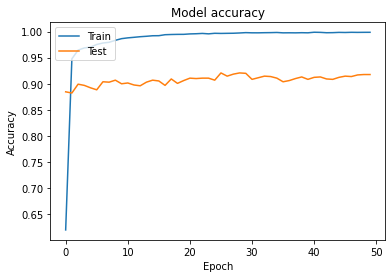

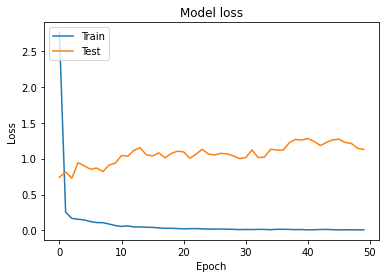

In [47]:
plot.plot(trained.history['accuracy'])
plot.plot(trained.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [48]:
from sklearn.metrics import classification_report
print(classification_report(Labels_test, np.argmax(model.predict(Images_test), axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       0.83      1.00      0.91         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      0.80      0.89         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       0.80      0.80      0.80         5
          15       1.00      1.00      1.00         5
          16       0.83      1.00      0.91         5
          17       0.83    

# Testing on an image from the internet of different birds

In [1]:
! curl https://i.pinimg.com/originals/ff/3b/b7/ff3bb7882fccf922be149677947e7430.jpg --output testbird.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 59540  100 59540    0     0   880k      0 --:--:-- --:--:-- --:--:--  880k


In [ ]:
test_image = cv2.imread('./testbird.jpg')
test_image = cv2.resize(test_image, (224, 224))


In [51]:
test_image_arr = []
test_image_arr.append(test_image)
test_image = np.array(test_image_arr)
test_image_pred = model.predict(test_image)

In [52]:
get_classlabel(int(np.argmax(test_image_pred, axis=1)))

'HIMALAYAN MONAL'

Not correct.